In [ ]:
# default_exp data.dataset

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

# Datasets
> Classes used to create `pytorch` compatible datasets.

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
from grade_classif.data.loaders import ImageLoader, MaskLoader, CategoryLoader
from grade_classif.data.utils import show_img, np_to_tensor
from grade_classif.data.read import get_items
from grade_classif.core import ifnone
from grade_classif.imports import *
from albumentations import Compose
from torch.utils.data import Dataset

In [ ]:
data = Path.cwd()/'sample_data/Patches_MGI_256_5'

In [ ]:
# export
class MyDataset(Dataset):
    """
    """
    def __init__(self, items, labels, item_loader, label_loader):
        super().__init__()
        self.items = np.array(items)
        self.labels = np.array(labels)
        self.item_loader = item_loader
        self.label_loader = label_loader
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, i):
        item, label = self.items[i], self.labels[i]
        x = self.item_loader(item)
        y = self.label_loader(label)
        return x, y
    
    @classmethod
    def from_folder(cls, folder, label_func, item_loader, label_loader, after_open=None, recurse=True, extensions=None, include=None, exclude=None, filterfunc=None):
        """
        Creates a `MyDataset` object by reading files from a folder. It uses `get_item` and therefore works the same. 
        """
        folder = Path(folder)
        items, labels = get_items(folder, label_func, recurse=recurse, extensions=extensions, include=include, exclude=exclude, filterfunc=None)
        return cls(items, labels, item_loader, label_loader)
    
    def to_tensor(self, tfms=None, tfm_y=True):
        """
        Creates a `TensorDataset` based on this dataset.
        """
        return TensorDataset(self, tfms=tfms, tfm_y=tfm_y)
    
    def split_by_list(self, train, valid, test=None):
        """
        Creates a `SplitDataset` using `train`, `valid` and optionally `test` tuples. Each tuple contains 2 lists: one for items and one for labels.
        """
        return SplitDataset(self.__class__(train[0], train[1], self.item_loader, self.label_loader),
                            self.__class__(valid[0], valid[1], self.item_loader, self.label_loader),
                            None if test is None else self.__class__(test[0], test[1], self.item_loader, self.label_loader))
    
    def split_by_folder(self):
        """
        Creates a `SplitDataset` by looking for `ŧrain`, `valid` and `test` in item paths and splitting the dataset accordingly.
        """
        train = ([], [])
        valid = ([], [])
        test = ([], [])
        for item, label in zip(self.items, self.labels):
            if 'train' in item.parts:
                train[0].append(item)
                train[1].append(label)
            elif 'valid' in item.parts:
                valid[0].append(item)
                valid[1].append(label)
            elif 'test' in item.parts:
                test[0].append(item)
                test[1].append(label)
        if test[0] == []:
            test = None
        return self.split_by_list(train, valid, test)
    
    def split_by_csv(self, csv, split_column='split', id_column='scan', get_id=None):
        """
        Creates a `SplitDataset` by using a csv that contains an `id_column` column for identifying items
        and a `split_column` column that contains either `'train'`, `'valid'` or `'test'`. `get_id` is the
        function used to extract the item's id from the item itself. By default it considers that `item` is a
        `Path` object and takes the parent folder's name as id.
        """
        get_id = ifnone(get_id, lambda x: x.parent.name)
        df = pd.read_csv(csv, header='infer')
        train = ([], [])
        valid = ([], [])
        test = ([], [])
        train_ids = df.loc[df[split_column] == 'train', id_column]
        valid_ids = df.loc[df[split_column] == 'valid', id_column]
        test_ids = df.loc[df[split_column] == 'test', id_column]
        for item, label in zip(self.items, self.labels):
            item_id = get_id(item)
            if item_id in train_ids.values:
                train[0].append(item)
                train[1].append(label) 
            elif item_id in valid_ids.values:
                valid[0].append(item)
                valid[1].append(label)
            elif item_id in test_ids.values:
                test[0].append(item)
                test[1].append(label)
        if test[0] == []:
            test = None
        return self.split_by_list(train, valid, test)    

Base class for all datasets. It is constructed using list of `items` and `labels`, most of the time as `Path` or `str` objects, with corresponding `item_loader` and `label_loader` as `ItemLoader` objects.

In [ ]:
show_doc(MyDataset.from_folder)

<h4 id="MyDataset.from_folder" class="doc_header"><code>MyDataset.from_folder</code><a href="__main__.py#L21" class="source_link" style="float:right">[source]</a></h4>

> <code>MyDataset.from_folder</code>(**`folder`**, **`label_func`**, **`item_loader`**, **`label_loader`**, **`after_open`**=*`None`*, **`recurse`**=*`True`*, **`extensions`**=*`None`*, **`include`**=*`None`*, **`exclude`**=*`None`*)

Creates a [`MyDataset`](data.dataset.html#MyDataset) object by reading files from a folder. It uses `get_item` and therefore works the same. 

In [ ]:
ds = MyDataset.from_folder(data, lambda x: x.parts[-3], ImageLoader(), CategoryLoader(classes=['1', '3']))
ds.items[::20], ds.labels[::20]

(array([PosixPath('/home/DeepLearning/grade_classif/nbs/sample_data/Patches_MGI_256_5/1/CF_PACS04rescan_07P0201/CF_PACS04rescan_07P0201_40960_131072.png'),
        PosixPath('/home/DeepLearning/grade_classif/nbs/sample_data/Patches_MGI_256_5/1/CF_PACS04rescan_07P0201/CF_PACS04rescan_07P0201_40960_81920.png'),
        PosixPath('/home/DeepLearning/grade_classif/nbs/sample_data/Patches_MGI_256_5/1/CF_PACS05HE_03026-04H2669/CF_PACS05HE_03026-04H2669_57344_155648.png'),
        ...,
        PosixPath('/home/DeepLearning/grade_classif/nbs/sample_data/Patches_MGI_256_5/3/CF_PACS05HE_06003-172.608I/CF_PACS05HE_06003-172.608I_0_163840.png'),
        PosixPath('/home/DeepLearning/grade_classif/nbs/sample_data/Patches_MGI_256_5/3/CF_PACS05HE_06003-172.608I/CF_PACS05HE_06003-172.608I_40960_114688.png'),
        PosixPath('/home/DeepLearning/grade_classif/nbs/sample_data/Patches_MGI_256_5/3/CF_PACS05HE_06003-172.608I/CF_PACS05HE_06003-172.608I_32768_139264.png')],
       dtype=object), array(['1',

In [ ]:
show_doc(MyDataset.to_tensor)

<h4 id="MyDataset.to_tensor" class="doc_header"><code>MyDataset.to_tensor</code><a href="__main__.py#L30" class="source_link" style="float:right">[source]</a></h4>

> <code>MyDataset.to_tensor</code>(**`tfms`**=*`None`*, **`tfm_y`**=*`True`*)

Creates a [`TensorDataset`](data.dataset.html#TensorDataset) based on this dataset.

In [ ]:
show_doc(MyDataset.split_by_list)

<h4 id="MyDataset.split_by_list" class="doc_header"><code>MyDataset.split_by_list</code><a href="__main__.py#L36" class="source_link" style="float:right">[source]</a></h4>

> <code>MyDataset.split_by_list</code>(**`train`**, **`valid`**, **`test`**=*`None`*)

Creates a [`SplitDataset`](data.dataset.html#SplitDataset) using [`train`](train.html), `valid` and optionally `test` tuples. Each tuple contains 2 lists: one for items and one for labels.

In [ ]:
show_doc(MyDataset.split_by_folder)

<h4 id="MyDataset.split_by_folder" class="doc_header"><code>MyDataset.split_by_folder</code><a href="__main__.py#L44" class="source_link" style="float:right">[source]</a></h4>

> <code>MyDataset.split_by_folder</code>()

Creates a [`SplitDataset`](data.dataset.html#SplitDataset) by looking for `ŧrain`, `valid` and `test` in item paths and splitting the dataset accordingly.

In [ ]:
show_doc(MyDataset.split_by_csv)

<h4 id="MyDataset.split_by_csv" class="doc_header"><code>MyDataset.split_by_csv</code><a href="__main__.py#L65" class="source_link" style="float:right">[source]</a></h4>

> <code>MyDataset.split_by_csv</code>(**`csv`**, **`split_column`**=*`'split'`*, **`id_column`**=*`'scan'`*, **`get_id`**=*`None`*)

Creates a [`SplitDataset`](data.dataset.html#SplitDataset) by using a csv that contains an `id_column` column for identifying items
and a `split_column` column that contains either `'train'`, `'valid'` or `'test'`. `get_id` is the
function used to extract the item's id from the item itself. By default it considers that `item` is a
`Path` object and takes the parent folder's name as id.

In [ ]:
# export
class ClassDataset(MyDataset):
    def __init__(self, *args, n_classes=2, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_classes = n_classes

`MyDataset` subclass for classification. Stores an additionnal `n_classes` attribute.

In [ ]:
# export
class ImageClassifDataset(ClassDataset):
    def show(self, k, ax=None, figsize=(3,3), hide_axis=True, cmap='viridis', **kwargs):
        """
        Shows the `k`th image from the dataset with the corresponding label.
        """
        x, y  = self[k]
        y = self.label_loader.classes[y]
        ax = show_img(x, ax=ax, hide_axis=hide_axis, cmap=cmap, figsize=figsize, title=str(y), **kwargs)
        
    def show_rand(self, ax=None, figsize=(3,3), hide_axis=True, cmap='viridis', **kwargs):
        """
        Shows a random image from the dataset with the corresponding label.
        """
        k = random.randint(0, len(self)-1)
        self.show(k, ax=ax, figsize=figsize, hide_axis=hide_axis, cmap=cmap, **kwargs)
        
    @classmethod
    def from_folder(cls, folder, label_func, n_classes=None, classes=None, recurse=True, extensions=None, include=None, exclude=None, filterfunc=None, **kwargs):
        """
        Overwrites `MyDataset.from_folder`. Works basically the same but you don't need to pass loaders, but instead `n_classes`
        or `classes` arguments. Loaders are automatically created using these.
        """
        folder = Path(folder)
        items, labels = get_items(folder, label_func, recurse=recurse, extensions=extensions, include=include, exclude=exclude, filterfunc=filterfunc)
        return cls(items, labels, ImageLoader(**kwargs), CategoryLoader(n_classes, classes), n_classes=ifnone(n_classes, len(classes)))

In [ ]:
show_doc(ImageClassifDataset.from_folder)

<h4 id="ImageClassifDataset.from_folder" class="doc_header"><code>ImageClassifDataset.from_folder</code><a href="__main__.py#L18" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageClassifDataset.from_folder</code>(**`folder`**, **`label_func`**, **`n_classes`**=*`None`*, **`classes`**=*`None`*, **`recurse`**=*`True`*, **`extensions`**=*`None`*, **`include`**=*`None`*, **`exclude`**=*`None`*, **\*\*`kwargs`**)

Overwrites [`MyDataset.from_folder`](data.dataset.html#MyDataset.from_folder). Works basically the same but you don't need to pass loaders, but instead `n_classes`
or `classes` arguments. Loaders are automatically created using these.

`ClassDataset` subclass for image classification.

In [ ]:
ds = ImageClassifDataset.from_folder(data, lambda x: x.parts[-3], classes=['1', '3'])

In [ ]:
show_doc(ImageClassifDataset.show)

<h4 id="ImageClassifDataset.show" class="doc_header"><code>ImageClassifDataset.show</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageClassifDataset.show</code>(**`k`**, **`ax`**=*`None`*, **`figsize`**=*`(3, 3)`*, **`hide_axis`**=*`True`*, **`cmap`**=*`'viridis'`*, **\*\*`kwargs`**)

Shows the `k`th image from the dataset with the corresponding label.

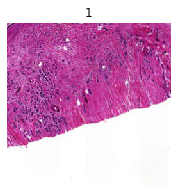

In [ ]:
ds.show(0)

In [ ]:
show_doc(ImageClassifDataset.show_rand)

<h4 id="ImageClassifDataset.show_rand" class="doc_header"><code>ImageClassifDataset.show_rand</code><a href="__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageClassifDataset.show_rand</code>(**`ax`**=*`None`*, **`figsize`**=*`(3, 3)`*, **`hide_axis`**=*`True`*, **`cmap`**=*`'viridis'`*, **\*\*`kwargs`**)

Shows a random image from the dataset with the corresponding label.

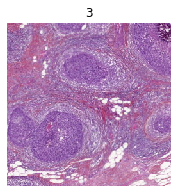

In [ ]:
ds.show_rand()

In [ ]:
# export
class ImageSegmentDataset(ClassDataset):
    def show(self, k, ax=None, figsize=(3,3), title=None, hide_axis=True, cmap='tab20', **kwargs):
        """
        Shows the `k`th image from the dataset with the corresponding mask above it.
        """
        x, y  = self[k]
        ax = show_img(x, ax=ax, hide_axis=hide_axis, cmap=cmap, figsize=figsize, **kwargs)
        ax = show_img(y, ax=ax, hide_axis=hide_axis, cmap=cmap, figsize=figsize,
                        interpolation='nearest', alpha=alpha, vmin=0, title=title, **kwargs)

    def show_rand(self, ax=None, figsize=(3,3), hide_axis=True, cmap='tab20', **kwargs):
        """
        Shows a random image from the dataset withthe corresponding mask above it.
        """
        k = random.randint(0, len(self)-1)
        self.show(k, ax=ax, figsize=figsize, hide_axis=hide_axis, cmap=cmap, **kwargs)
        
    @classmethod
    def from_folder(cls, folder, label_func, n_classes=None, classes=None, recurse=True, extensions=None, include=None, exclude=None, filterfunc=None):
        """
        Same as `ImageClassifDataset.from_folder`.
        """
        folder = Path(folder)
        items, labels = get_items(folder, label_func, recurse=recurse, extensions=extensions, include=include, exclude=exclude, filterfunc=filtefunc)
        return cls(items, labels, ImageLoader(), MaskLoader(), n_classes=ifnone(n_classes, len(classes)))

`ClassDataset` subclass for image segmentation.

In [ ]:
show_doc(ImageSegmentDataset.from_folder)

<h4 id="ImageSegmentDataset.from_folder" class="doc_header"><code>ImageSegmentDataset.from_folder</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageSegmentDataset.from_folder</code>(**`folder`**, **`label_func`**, **`n_classes`**=*`None`*, **`classes`**=*`None`*, **`recurse`**=*`True`*, **`extensions`**=*`None`*, **`include`**=*`None`*, **`exclude`**=*`None`*)

Same as [`ImageClassifDataset.from_folder`](data.dataset.html#ImageClassifDataset.from_folder).

In [ ]:
show_doc(ImageSegmentDataset.show)

<h4 id="ImageSegmentDataset.show" class="doc_header"><code>ImageSegmentDataset.show</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageSegmentDataset.show</code>(**`k`**, **`ax`**=*`None`*, **`figsize`**=*`(3, 3)`*, **`title`**=*`None`*, **`hide_axis`**=*`True`*, **`cmap`**=*`'tab20'`*, **\*\*`kwargs`**)

Shows the `k`th image from the dataset with the corresponding mask above it.

In [ ]:
show_doc(ImageSegmentDataset.show_rand)

<h4 id="ImageSegmentDataset.show_rand" class="doc_header"><code>ImageSegmentDataset.show_rand</code><a href="__main__.py#L12" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageSegmentDataset.show_rand</code>(**`ax`**=*`None`*, **`figsize`**=*`(3, 3)`*, **`hide_axis`**=*`True`*, **`cmap`**=*`'tab20'`*, **\*\*`kwargs`**)

Shows a random image from the dataset withthe corresponding mask above it.

In [ ]:
# export
class NormDataset(MyDataset):
    def show(self, k, axs=None, figsize=(5, 5), title=None, hide_axis=True, cmap='viridis', **kwargs):
        """
        Shows the `k`th image from the dataset as grayscale and colored.
        """
        x, y  = self[k]
        axs = ifnone(axs, plt.subplots(1, 2, figsize=figsize)[1])
        ax = show_img(x, ax=axs[0], hide_axis=hide_axis, cmap=cmap, figsize=figsize, **kwargs)
        ax = show_img(y, ax=axs[1], hide_axis=hide_axis, cmap=cmap, figsize=figsize, **kwargs)

    def show_rand(self, axs=None, figsize=(5, 5), hide_axis=True, cmap='viridis', **kwargs):
        """
        Shows a random image from the dataset as grayscale and colored.
        """
        k = random.randint(0, len(self)-1)
        self.show(k, axs=axs, figsize=figsize, hide_axis=hide_axis, cmap=cmap, **kwargs)
        
    @classmethod
    def from_folder(cls, folder, id_column='scan', recurse=True, extensions=None, include=None, exclude=None):
        """
        Overwrites `MyDataset.from_folder` so that it doesn't need the loaders or a `label_func`.
        """
        def _label_func(x):
            return x  
        folder = Path(folder)
        items, labels = get_items(folder, _label_func, recurse=recurse, extensions=extensions, include=include, exclude=exclude)
        return cls(items, labels, ImageLoader(open_mode='3G'), ImageLoader())

In [ ]:
show_doc(NormDataset.from_folder)

<h4 id="NormDataset.from_folder" class="doc_header"><code>NormDataset.from_folder</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>NormDataset.from_folder</code>(**`folder`**, **`csv`**, **`id_column`**=*`'scan'`*, **`recurse`**=*`True`*, **`extensions`**=*`None`*, **`include`**=*`None`*, **`exclude`**=*`None`*)

Overwrites [`MyDataset.from_folder`](data.dataset.html#MyDataset.from_folder) so that it doesn't need the loaders or a `label_func`. It howevers requires a `csv` 
argument that contains an `id_column` column to identify images and a `'category'` column that contains 1 if the image 
is to be used for normalization.

`MyDataset` subclass to use for a grayscale to color unet.

In [ ]:
ds = NormDataset.from_folder(data, data.parent/'categories.csv')

In [ ]:
show_doc(NormDataset.show)

<h4 id="NormDataset.show" class="doc_header"><code>NormDataset.show</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>NormDataset.show</code>(**`k`**, **`axs`**=*`None`*, **`figsize`**=*`(5, 5)`*, **`title`**=*`None`*, **`hide_axis`**=*`True`*, **`cmap`**=*`'viridis'`*, **\*\*`kwargs`**)

Shows the `k`th image from the dataset as grayscale and colored.

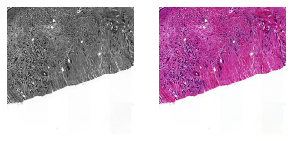

In [ ]:
ds.show(0)

In [ ]:
show_doc(NormDataset.show_rand)

<h4 id="NormDataset.show_rand" class="doc_header"><code>NormDataset.show_rand</code><a href="__main__.py#L12" class="source_link" style="float:right">[source]</a></h4>

> <code>NormDataset.show_rand</code>(**`axs`**=*`None`*, **`figsize`**=*`(5, 5)`*, **`hide_axis`**=*`True`*, **`cmap`**=*`'viridis'`*, **\*\*`kwargs`**)

Shows a random image from the dataset as grayscale and colored.

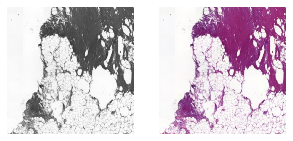

In [ ]:
ds.show_rand()

In [ ]:
# export
@dataclass
class SplitDataset:
    """
    """
    train: Dataset
    valid: Dataset
    test: Dataset = None
        
    def to_tensor(self, tfms=None, tfm_y=True, test_tfms=None):
        """
        Transforms all datasets into `TensorDataset` objects
        """
        tfms = ifnone(tfms, (None, None))
        self.train = self.train.to_tensor(tfms=tfms[0], tfm_y=tfm_y)
        self.valid = self.valid.to_tensor(tfms=tfms[1], tfm_y=tfm_y)
        if self.test is not None:
            self.test = self.test.to_tensor(tfms=test_tfms, tfm_y=tfm_y)
        return self

Wrapper that contains a `train`, a `valid` and optionally a `test` datasets.

In [ ]:
show_doc(SplitDataset.to_tensor)

<h4 id="SplitDataset.to_tensor" class="doc_header"><code>SplitDataset.to_tensor</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>SplitDataset.to_tensor</code>(**`tfms`**=*`None`*, **`tfm_y`**=*`True`*, **`test_tfms`**=*`None`*)

Transforms all datasets into [`TensorDataset`](data.dataset.html#TensorDataset) objects

In [ ]:
# export
class TensorDataset(Dataset):
    """
    """
    def __init__(self, ds, tfms=None, tfm_y=True):
        self._ds = ds
        self.tfms = ifnone(tfms, [])
        self.tfm_y = tfm_y
        
    def __len__(self):
        return len(self._ds)
    
    def __getitem__(self, i):
        x, y = self._ds[i]
        if self.tfms != []:
            aug = Compose(self.tfms)
            augmented = aug(image=x, mask=y if self.tfm_y else None)
            x = augmented['image']
            if self.tfm_y: 
                y = augmented['mask']
        x = np_to_tensor(x, type(self._ds.item_loader).__name__.lower().replace('loader', ''))
        y = np_to_tensor(y, type(self._ds.label_loader).__name__.lower().replace('loader', ''))
        return x, y
    
    def get_orig_tfmed(self, i):
        x, _ = self._ds[i]
        if self.tfms != []:
            aug = Compose(self.tfms)
            augmented = aug(image=x)
            x_tfmed = augmented['image']
        else:
            x_tfmed = x
        return x, x_tfmed
    
    def __getattr__(self, name):
        return getattr(self._ds, name)

Wrapper around a dataset that generates tensors from the outputs of the dataset's `__getitem__` method using `np_to_tensor`. Can also apply transforms using [albumentations](https://albumentations.readthedocs.io/en/latest/). Pass `tfm_y=False` if you don't want to apply transforms to `y` (when doing classification for instance). Loaders should be instances of `ImageLoader`, `MaskLoader` or `CategoryLoader` for it to work correctly.

In [ ]:
tds = ds.to_tensor()
tds[0]

(tensor([[[0.4549, 0.4784, 0.4157,  ..., 0.4039, 0.5059, 0.4275],
          [0.3765, 0.4392, 0.4745,  ..., 0.4784, 0.4667, 0.5020],
          [0.4941, 0.4510, 0.4510,  ..., 0.5686, 0.4275, 0.5412],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.4549, 0.4784, 0.4157,  ..., 0.4039, 0.5059, 0.4275],
          [0.3765, 0.4392, 0.4745,  ..., 0.4784, 0.4667, 0.5020],
          [0.4941, 0.4510, 0.4510,  ..., 0.5686, 0.4275, 0.5412],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.4549, 0.4784, 0.4157,  ..., 0.4039, 0.5059, 0.4275],
          [0.3765, 0.4392, 0.4745,  ..., 0.4784, 0.4667, 0.5020],
          [0.4941, 0.4510, 0.4510,  ...,

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_train.ipynb.
Converted 02_predict.ipynb.
Converted 10_data.read.ipynb.
Converted 11_data.loaders.ipynb.
Converted 12_data.dataset.ipynb.
Converted 13_data.utils.ipynb.
Converted 14_data.transforms.ipynb.
Converted 20_models.plmodules.ipynb.
Converted 21_models.modules.ipynb.
Converted 22_models.utils.ipynb.
Converted 23_models.hooks.ipynb.
Converted 24_models.metrics.ipynb.
Converted 25_models.losses.ipynb.
Converted 80_params.defaults.ipynb.
Converted 81_params.parser.ipynb.
Converted 99_index.ipynb.
